In [1]:
import numpy as np
import os
import torch
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.externals import joblib

from pytorch_utils.cfvae_models import CFVAEModel

In [2]:
outcome = 'los'
sensitive_variable = 'age'
data_path = 'data/'

features_path = os.path.join(data_path, 'features', str(0), '{}_excluded'.format(sensitive_variable))
label_path = os.path.join(data_path, 'labels')
checkpoints_path = os.path.join(data_path, 'checkpoints', 'scratch', outcome)
performance_path = os.path.join(data_path, 'performance', 'scratch', outcome)

In [3]:
config_load_path = os.path.join(data_path, 'config', 'defaults', 'cfvae', outcome, sensitive_variable, 'model_config.yaml')
checkpoint_load_path = os.path.join(data_path, 'checkpoints', 'cfvae_default', outcome, sensitive_variable, str(0))
os.listdir(checkpoint_load_path)[0]

'1552673022.8390067.chk'

In [4]:
os.makedirs(checkpoints_path, exist_ok=True)
os.makedirs(performance_path, exist_ok=True)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
features_dict = joblib.load(os.path.join(features_path, 'features.pkl'))
master_label_dict = joblib.load(os.path.join(label_path, 'label_dict.pkl'))

In [7]:
data_dict = {split: features_dict[split]['features'] for split in features_dict.keys()}
label_dict = {split : master_label_dict[split][outcome] for split in master_label_dict.keys()}
group_dict = {split : master_label_dict[split][sensitive_variable] for split in master_label_dict.keys()}

In [8]:
group_map = pd.read_csv(os.path.join(label_path, '{}_map.csv'.format(sensitive_variable)))

In [9]:
group_map

,category_id,categories
0,0,"[18, 30)"
1,1,"[30, 45)"
2,2,"[45, 65)"
3,3,"[65, 89)"


In [10]:
with open(config_load_path, 'r') as fp:
    config_dict = yaml.load(fp)

In [11]:
config_dict

{'batch_size': 512,
 'drop_prob': 0.25,
 'drop_prob_classifier': 0.25,
 'gamma': None,
 'group_embed_dim': 64,
 'hidden_dim_classifier': 128,
 'input_dim': 368113,
 'iters_per_epoch': 100,
 'lambda_classification': 10.0,
 'lambda_kl': 0.0,
 'lambda_mmd': 10000.0,
 'lambda_mmd_group': 1000.0,
 'lambda_reconstruction': 1000.0,
 'latent_dim': 128,
 'lr': 0.0001,
 'lr_final_classifier': 0.001,
 'normalize': False,
 'normalize_classifier': True,
 'num_epochs': 20,
 'num_groups': 4,
 'num_hidden': 1,
 'num_hidden_classifier': 2,
 'output_dim': 2,
 'resnet': False,
 'resnet_classifier': False,
 'sparse': True,
 'sparse_mode': 'binary'}

In [12]:
config_dict_final_classifier = {
    'lr_final_classifier' : 1e-2,
    'lambda_final_classifier_cf' : 1e0,
    'lambda_clp' : 1e1,
    'lambda_clp_entropy' : 0e0,
    'num_epochs' : 3,
    'weighted' : False,
    'num_samples_eval': 1,
    'cf_gradients' : True
}

# config_dict_final_classifier = {
#     'lr_final_classifier' : 1e-2,
#     'lambda_final_classifier_cf' : 0e0,
#     'lambda_clp' : 0e1,
#     'lambda_clp_entropy' : 0e0,
#     'num_epochs' : 3,
#     'weighted' : False,
#     'num_samples_eval': 1,
#     'cf_gradients' : True
# }

config_dict.update(config_dict_final_classifier)

In [13]:
if sensitive_variable == 'gender':
    data_dict = {k: v[group_dict[k] < 2] for k,v in data_dict.items()}
    label_dict = {k: v[group_dict[k] < 2] for k,v in label_dict.items()}
    group_dict = {k: v[group_dict[k] < 2] for k,v in group_dict.items()}

In [14]:
model = CFVAEModel(config_dict)

In [15]:
model.load_weights(os.path.join(checkpoint_load_path, os.listdir(checkpoint_load_path)[0]))

In [16]:
result = model.train_final_classifier(data_dict, label_dict, group_dict)

Epoch 0/2
----------
Phase: train:
 loss: 1.618458, classification: 0.556421, classification_cf: 0.737681, clp: 0.032436, clp_entropy: 1.127063,
 auc: 0.666367, auprc: 0.290442, brier: 0.183493,
Phase: val:
 loss: 1.284981, classification: 0.544153, classification_cf: 0.740764, clp: 0.000006, clp_entropy: 1.045486,
 auc: 0.764500, auprc: 0.460651, brier: 0.177541,
Best model updated
Epoch 1/2
----------
Phase: train:
 loss: 1.284625, classification: 0.533819, classification_cf: 0.743010, clp: 0.000780, clp_entropy: 1.108073,
 auc: 0.778660, auprc: 0.472686, brier: 0.173170,
Phase: val:
 loss: 1.275553, classification: 0.529511, classification_cf: 0.745945, clp: 0.000010, clp_entropy: 1.037441,
 auc: 0.794727, auprc: 0.522016, brier: 0.171019,
Best model updated
Epoch 2/2
----------
Phase: train:
 loss: 1.274699, classification: 0.514965, classification_cf: 0.745235, clp: 0.001450, clp_entropy: 1.103419,
 auc: 0.858061, auprc: 0.649979, brier: 0.164484,
Phase: val:
 loss: 1.262736, clas

In [17]:
result_eval = model.predict_final_classifier(data_dict, label_dict, group_dict, phases = ['val', 'test'])
result_eval[1]

{'val': {'auc': [0.825539078001845],
  'auprc': [0.5588711810459277],
  'brier': [0.16120478216346515],
  'loss': [0.507599691932018],
  'classification': [0.507599691932018]},
 'test': {'auc': [0.8244146102356522],
  'auprc': [0.5499909035405806],
  'brier': [0.15974788047325578],
  'loss': [0.5046461362105149],
  'classification': [0.5046461362105149]}}

In [18]:
result_eval_CLP = model.predict_final_classifier_CLP(data_dict, label_dict, group_dict, 
                                                     phases = ['val', 'test'])

In [31]:
result_eval_CLP[1]

{'val': {'auc': [0.8256910316934896],
  'auprc': [0.561822189915584],
  'brier': [0.1611639093630116],
  'loss': [0.995547333588967],
  'classification': [0.5075307007019336],
  'classification_cf': [0.4877538841504317],
  'clp': [2.6159439184937334e-05],
  'clp_entropy': [1.2887992344189632]},
 'test': {'auc': [0.8260907493658395],
  'auprc': [0.5587007121167546],
  'brier': [0.15951666427761113],
  'loss': [0.9859082102775574],
  'classification': [0.5040558267098206],
  'classification_cf': [0.48160679179888505],
  'clp': [2.45458717643688e-05],
  'clp_entropy': [1.2878924568587364]}}

In [19]:
cf_dict = result_eval_CLP[2]
cf_df = pd.concat({key: pd.DataFrame(cf_dict[key]) for key in cf_dict.keys()}).rename_axis(index = ['phase', 'id']).reset_index(0)

In [20]:
cf_df.head()

,phase,y,y_cf,group,group_cf,pred_prob_factual,pred_prob_cf,output_factual,output_cf
id,,,,,,,,,
0,test,0,0,3,0,0.306381,0.308052,-0.402464,-0.398760
1,test,0,0,3,0,0.335598,0.335954,-0.339049,-0.338284
2,test,0,0,2,0,0.292647,0.293397,-0.435283,-0.433549
3,test,0,0,2,0,0.345323,0.344936,-0.315603,-0.316597
4,test,1,1,2,0,0.485430,0.484431,-0.026548,-0.027873


In [21]:
cf_df = cf_df.assign(pred_diff = lambda x: x.pred_prob_cf - x.pred_prob_factual)
cf_df.head(10)

,phase,y,y_cf,group,group_cf,pred_prob_factual,pred_prob_cf,output_factual,output_cf,pred_diff
id,,,,,,,,,,
0,test,0,0,3,0,0.306381,0.308052,-0.402464,-0.398760,0.001671
1,test,0,0,3,0,0.335598,0.335954,-0.339049,-0.338284,0.000356
2,test,0,0,2,0,0.292647,0.293397,-0.435283,-0.433549,0.000751
3,test,0,0,2,0,0.345323,0.344936,-0.315603,-0.316597,-0.000387
4,test,1,1,2,0,0.485430,0.484431,-0.026548,-0.027873,-0.000999
5,test,1,1,2,0,0.405323,0.405951,-0.189375,-0.187772,0.000628
6,test,0,0,3,0,0.297474,0.298799,-0.423657,-0.420655,0.001326
7,test,0,0,2,0,0.324245,0.322907,-0.365168,-0.368266,-0.001338
8,test,1,1,3,0,0.499010,0.496463,0.000195,-0.004287,-0.002547


In [22]:
cf_df.groupby(['y', 'y_cf']).apply(lambda x: x.shape)

y  y_cf
0  0       (55301, 10)
   1        (7069, 10)
1  0        (8757, 10)
   1        (6654, 10)
dtype: object

In [23]:
result = cf_df.groupby(['phase', 'y', 'y_cf', 'group', 'group_cf'])[['pred_diff']].agg(np.mean)

In [24]:
result = result.reset_index()

0 0


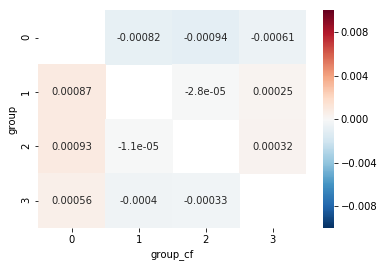

0 1


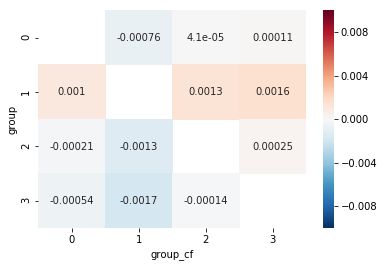

1 0


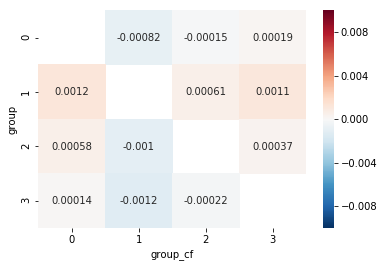

1 1


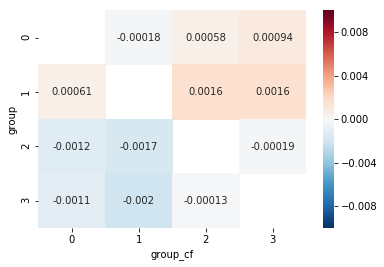

In [26]:
for y in [0, 1]:
    for y_cf in [0, 1]:
        print(y, y_cf)
        temp = result[(result.phase == 'val') & (result.y == y) & (result.y_cf == y_cf)]
        temp = temp.pivot('group', 'group_cf', 'pred_diff')
        ax = sns.heatmap(temp, annot = True, center = 0, cmap = 'RdBu_r', vmin = -0.01, vmax = 0.01)
        plt.show()

In [27]:
# from sklearn.calibration import calibration_curve

# cal = calibration_curve(cf_df.y, cf_df.pred_prob_factual, n_bins = 10)
# print(cal)

(array([0.03280853, 0.20285449, 0.55989331, 0.88034188]), array([0.29219994, 0.34277037, 0.43774855, 0.51083163]))


In [28]:
## Get performance by group
sensitive_variables = ['age', 'gender', 'race_eth']
data_dict_by_group = {sensitive_variable: {} for sensitive_variable in sensitive_variables}
label_dict_by_group = {sensitive_variable: {} for sensitive_variable in sensitive_variables}
group_dict_by_group = {sensitive_variable: {} for sensitive_variable in sensitive_variables}
for sensitive_variable in sensitive_variables:
    groups = np.unique(master_label_dict['train'][sensitive_variable])
    for group in groups:
        data_dict_by_group[sensitive_variable][group] = {split: 
                                     data_dict[split][master_label_dict[split][sensitive_variable] == group]
                                     for split in data_dict.keys()
                                    }
        label_dict_by_group[sensitive_variable][group] = {split: 
                                     label_dict[split][master_label_dict[split][sensitive_variable] == group]
                                     for split in data_dict.keys()
                                    }
        group_dict_by_group[sensitive_variable][group] = {split: 
                                     group_dict[split][master_label_dict[split][sensitive_variable] == group]
                                     for split in data_dict.keys()
                                    }

result_df_by_group = pd.concat({sensitive_variable: 
                          pd.concat({
                              group: model.process_result_dict(model.predict_final_classifier(data_dict_by_group[sensitive_variable][group],
                                                                             label_dict_by_group[sensitive_variable][group], 
                                                                             group_dict_by_group[sensitive_variable][group],
                                                  phases = ['val', 'test'])[1])
                              for group in data_dict_by_group[sensitive_variable].keys()
                          })
                          for sensitive_variable in data_dict_by_group.keys()
                         })
result_df_by_group.index = result_df_by_group.index.set_names(['sensitive_variable', 'group', 'index'])
result_df_by_group = result_df_by_group.reset_index(level = [0, 1])
result_df_by_group.head()

,sensitive_variable,group,metric,phase,epoch,performance
index,,,,,,
0,age,0,auc,val,0,0.888709
1,age,0,auprc,val,0,0.648215
2,age,0,brier,val,0,0.152396
3,age,0,classification,val,0,0.488567
4,age,0,loss,val,0,0.488567


In [29]:
result_df_by_group.loc[(result_df_by_group.sensitive_variable == 'age') & (result_df_by_group.metric == 'auc')]

,sensitive_variable,group,metric,phase,epoch,performance
index,,,,,,
0,age,0,auc,val,0,0.888709
5,age,0,auc,test,0,0.858945
0,age,1,auc,val,0,0.861755
5,age,1,auc,test,0,0.856206
0,age,2,auc,val,0,0.814010
5,age,2,auc,test,0,0.828519
0,age,3,auc,val,0,0.801785
5,age,3,auc,test,0,0.796158
